In [ ]:
# !pip uninstall normalizer -y
!pip install normalizer


# !pip install normalizer

!pip install git+https://github.com/csebuetnlp/normalizer
!pip install --upgrade transformers
!pip install torch transformers datasets pandas scikit-learn


# Implementation


Using: cuda
Using BanglaBERT normalizer
Data: (6000, 4), Labels: {1: 3000, 0: 3000}


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/4800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.429100,0.465042,0.795833,0.795730,0.796434,0.795833
2,0.360300,0.434066,0.795833,0.794852,0.801605,0.795833
3,0.200300,0.474957,0.815833,0.815726,0.816573,0.815833
4,0.308900,0.741968,0.800000,0.799015,0.805998,0.800000
5,0.249900,1.332709,0.824167,0.824167,0.824168,0.824167
6,0.306200,2.300175,0.819167,0.818889,0.821137,0.819167
7,0.374100,2.817101,0.821667,0.821659,0.821724,0.821667
8,0.000100,2.851758,0.824167,0.823999,0.825404,0.824167
9,0.201000,2.862841,0.830000,0.829704,0.832308,0.830000
10,0.097600,2.872647,0.829167,0.828986,0.830563,0.829167


Training complete!



Results: Acc=0.830, F1=0.830, AUC=0.868


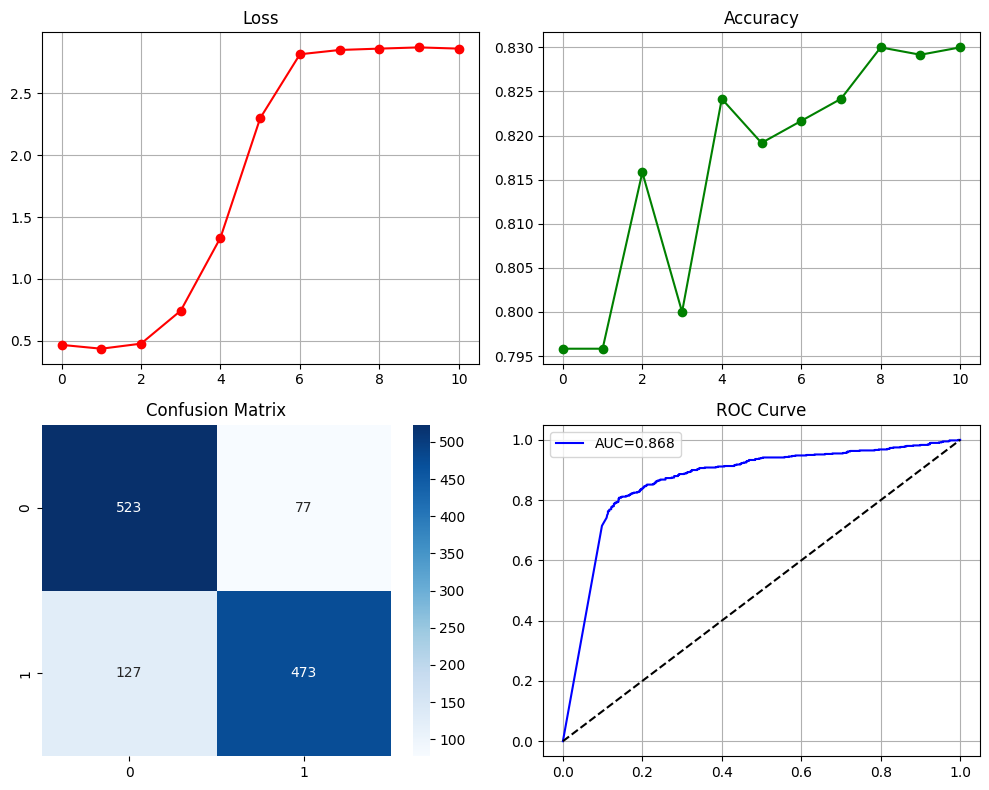

Model saved!
'আমি তোমাকে ভালোবাসি।' -> Non-Hate (1.000)
'তুমি একজন খারাপ মানুষ।' -> Hate (1.000)

🎉 Done! Use predict('text') for inference


In [22]:
# BanglaBERT Hate Speech Detection - Ultra Compact
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from datasets import Dataset
import torch
from collections import defaultdict
import warnings; warnings.filterwarnings('ignore')

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

# Load data
def load_data():
    for path in ['/kaggle/input/final-hate-speech/combined_final_hate_speech.csv', './combined_final_hate_speech.csv', 'combined_final_hate_speech.csv']:
        try: return pd.read_csv(path)
        except: continue
    raise FileNotFoundError("Dataset not found")

# Normalizer
try:
    from normalizer import normalize
    print("Using BanglaBERT normalizer")
except ImportError:
    print("Warning: Install normalizer with: pip install git+https://github.com/csebuetnlp/normalizer")
    normalize = lambda x: str(x).strip()

# Process data
df = load_data().dropna(subset=['Comment', 'Hate'])
df['text'] = df['Comment'].apply(lambda x: normalize(str(x)))
df['label'] = df['Hate'].map({'Yes': 1, 'No': 0, 'yes': 1, 'no': 0, 'YES': 1, 'NO': 0})
df = df.dropna(subset=['label']).astype({'label': int})
print(f"Data: {df.shape}, Labels: {df['label'].value_counts().to_dict()}")

# Split & tokenize
train_df, eval_df = train_test_split(df[['text', 'label']], test_size=0.2, random_state=42, stratify=df['label'])
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglabert")
model = AutoModelForSequenceClassification.from_pretrained("csebuetnlp/banglabert", num_labels=2).to(device)

def tokenize(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

train_dataset = Dataset.from_pandas(train_df).map(tokenize, batched=True)
eval_dataset = Dataset.from_pandas(eval_df).map(tokenize, batched=True)
for ds in [train_dataset, eval_dataset]:
    ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Trainer
class QuickTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.history = defaultdict(list)
    def log(self, logs, start_time=None):
        super().log(logs)
        for k, v in logs.items(): self.history[k].append(v)

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=1)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {'accuracy': accuracy_score(labels, preds), 'f1': f1, 'precision': p, 'recall': r}

# Train
trainer = QuickTrainer(
    model=model,
    args=TrainingArguments(
        
        output_dir='./results', 
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        num_train_epochs=10,
        weight_decay=0.01, 
        logging_steps=10, 
        report_to="none",
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        greater_is_better=True,
        fp16=torch.cuda.is_available(), 
        dataloader_num_workers=0
    ),
    train_dataset=train_dataset, eval_dataset=eval_dataset, compute_metrics=compute_metrics,
)

print("Training...")
trainer.train()
print("Training complete!")

# Evaluate
preds = trainer.predict(eval_dataset)
y_pred = np.argmax(preds.predictions, axis=1)
y_true = preds.label_ids
y_prob = torch.softmax(torch.tensor(preds.predictions), dim=1)[:, 1].numpy()

results = trainer.evaluate()
auc = roc_auc_score(y_true, y_prob)
print(f"\nResults: Acc={results['eval_accuracy']:.3f}, F1={results['eval_f1']:.3f}, AUC={auc:.3f}")

# Plots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
if 'eval_loss' in trainer.history:
    axes[0,0].plot(trainer.history['eval_loss'], 'r-o'); axes[0,0].set_title('Loss'); axes[0,0].grid()
if 'eval_accuracy' in trainer.history:
    axes[0,1].plot(trainer.history['eval_accuracy'], 'g-o'); axes[0,1].set_title('Accuracy'); axes[0,1].grid()
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', ax=axes[1,0], cmap='Blues'); axes[1,0].set_title('Confusion Matrix')
fpr, tpr, _ = roc_curve(y_true, y_prob)
axes[1,1].plot(fpr, tpr, 'b-', label=f'AUC={auc:.3f}')
axes[1,1].plot([0,1], [0,1], 'k--'); axes[1,1].set_title('ROC Curve'); axes[1,1].legend(); axes[1,1].grid()
plt.tight_layout(); plt.savefig('results.png', dpi=300, bbox_inches='tight'); plt.show()

# Save & predict
model.save_pretrained('./model'); tokenizer.save_pretrained('./model')
print("Model saved!")

def predict(text):
    inputs = tokenizer(normalize(text), return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1)[0]
    pred = torch.argmax(probs).item()
    return {'text': text, 'prediction': 'Hate' if pred == 1 else 'Non-Hate', 'confidence': probs.max().item()}

# Test
for text in ["আমি তোমাকে ভালোবাসি।", "তুমি একজন খারাপ মানুষ।"]:
    result = predict(text)
    print(f"'{text}' -> {result['prediction']} ({result['confidence']:.3f})")



# Hugging Face push (optional)
def push_to_hf(username, model_name="banglabert-hate-speech"):
    try:
        from huggingface_hub import login
        login()  # You'll need to enter your token
        repo_id = f"{username}/{model_name}"
        model.push_to_hub(repo_id)
        tokenizer.push_to_hub(repo_id)
        print(f"Model pushed to: https://huggingface.co/{repo_id}")
    except Exception as e:
        print(f"Push failed: {e}")

# Uncomment to push: push_to_hf("your_username")

print("\n🎉 Done! Use predict('text') for inference")

# Quick inference 

In [23]:
# Quick inference function

def predict(text):
    # Tokenize and normalize the input text
    inputs = tokenizer(normalize(text), return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Make prediction using the model
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1)[0]
    
    # Get the predicted class and probabilities
    pred = torch.argmax(probs).item()
    
    return {
        'text': text,
        'prediction': 'Hate' if pred == 1 else 'Non-Hate',
        'confidence': probs.max().item(),
        'hate_prob': probs[1].item()
    }

# Input text from the user
name_input = input("Enter text or name for classification: ")

# Predict and show the result
result = predict(name_input)
print(f"\n'{result['text']}' -> {result['prediction']} (Confidence: {result['confidence']:.3f})")

Enter text or name for classification:  gw



'gw' -> Hate (Confidence: 1.000)
